# Stock Market Prediction Using Financial News and Historical Data

Using sentiment analysis and recurrent neural network models (LSTM)
we combine ”public sentiment” and historical market data to find a predictor for ”market movment”. We use financial news datasets from Reuters to predict public mood given by the sentiment of the news headline. In addition, we use Dow Jones Industrial average closing price to predict next day movement. The model trained with time series features for the period '2006-10-20' to '2008-01-17' obtain ~%95 accuracy on the test set from '2008-01-17' to '2008-02-28 using the window size of 32 days.



In [2]:
#importing pkgs and libs:
import os
import sys
import string
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import yfinance as yf 
%matplotlib inline


## Financial news-data prepration

In [5]:
import requests

DIR_NAME = 'ReutersNews106521'
def get_data(DIR_NAME):
    '''
    Get Reuters Finacial News Data Set 
    @ https://github.com/duynht/financial-news-dataset
    '''
    
    if not os.path.exists(DIR_NAME):
        os.mkdir(DIR_NAME)
    url = "https://github.com/duynht/financial-news-dataset/financial-news-dataset-master.zip"
    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(DIR_NAME, name), 'w') as f:
        f.write(response.content)


In [3]:
#Load and parse Reuters Finacial News Data Set @ https://github.com/duynht/financial-news-dataset
DIR_NAME = 'ReutersNews106521'

def parse_data(DIR_NAME = 'ReutersNews106521', dir_limit = 500):
    
    '''
    parsing the news dataset folders and 
    extract news dates, titles and contents
    use small dir_limit arg to experiment first
    otherwise use full data set
    '''
    
    c = 0
    new_text = []
    titles = []
    dates = []
    contents = []

    for names in sorted(os.listdir(DIR_NAME)):
        c+=1
        path = os.path.join(DIR_NAME, names)
        if c < dir_limit:
            if os.path.isdir(path):
                for fname in sorted(os.listdir(path)):
                    fpath = os.path.join(path, fname)
                    if(not fpath.endswith('.DS_Store')):
                        with open(fpath, 'rb') as f:
                            t = f.read().decode('utf-8',errors='ignore')
                            new_text = t.split('\n-- ')
                            title, date, content = new_text[0].strip('--'), new_text[2], new_text[3] 
                            titles.append(title)
                            dates.append(date)
                            contents.append(content)
    return titles, dates, contents

#titles, dates, contents =  parse_date('ReutersNews106521', sys.maxsize)
titles, dates, contents =  parse_data('ReutersNews106521')

In [4]:
def clean_text(text, remove_common_words = True, stemming = True):
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # # filter out stop words
    from nltk.corpus import stopwords
    #stop_words = set(stopwords.words('english'))
    stop_words = set(stopwords.words('english')).union(
                  {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                   "set", "might", "says", "including", "lot", "much", "said", "know", 
                   "good", "step", "often", "going", "thing", "things", "think",
                  "back", "actually", "better", "look", "find", "right", "example", 
                   "verb", "verbs"})
    words = [w for w in words if not w in stop_words]
    p_stemmer = PorterStemmer()
    stemmed_tokens = [p_stemmer.stem(i) for i in words] if stemming else words
    fin_words = {"percent", "companies", "company", "stock", "sales", "million", "billion",
                   "share", "new", "market", "close", "earn", "report", "analyst", "expect", "unit",
                   "quarter", "year", "cents", "week", "profit", "rate", "price", "rose", "cost", "revenu", "offer", "post" }
    words = [w for w in stemmed_tokens if not w in fin_words]
    words = ' '.join(words)
    return words

In [8]:
clean_alltext = [clean_text(title) + ' ' + clean_text(content) for title, content in zip(titles, contents)]
clean_titles = [clean_text(title) for title in titles]

In [71]:
dates[-10:-1]

['Fri Feb 29, 2008 5:15pm EST',
 'Fri Feb 29, 2008 11:20am EST',
 'Fri Feb 29, 2008 3:32pm EST',
 'Fri Feb 29, 2008 11:00am EST',
 'Fri Feb 29, 2008 11:24am EST',
 'Fri Feb 29, 2008 10:13am EST',
 'Fri Feb 29, 2008 10:13am EST',
 'Fri Feb 29, 2008 3:37pm EST',
 'Fri Feb 29, 2008 6:31am EST']

## Topic Modeling

We analyze the topics in the news contents and titles using
Latent Dirichlet Allocation (LDA). First we preprocess the data using Tf-idf bag of words model to find the term-documnet frequency matrix. Then we apply LDA to the term-document matrix 
The assumption is that each document mix with various topics and every topic mix with various words.


In [9]:
def tfidf_vectorizer(prep_docs, n_features = 200, param_min_df = 2, param_max_df = 0.95):

    print("Extracting tf-idf features ...")
    tfidf = TfidfVectorizer(max_df = param_max_df, min_df = param_min_df,
                                       max_features=n_features,
                                       stop_words='english')
    # tfidf_vec_sparse = tfidf.fit_transform(docs)
    tfidf_vec_sparse = tfidf.fit_transform(prep_docs)
    feature_names = tfidf.get_feature_names()

    return tfidf_vec_sparse, feature_names

In [10]:
tfidf_vec_sparse, feature_names = tfidf_vectorizer(clean_alltext, n_features = None, param_min_df = 2, param_max_df = 0.95)


Extracting tf-idf features ...


In [11]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,

                                random_state=0)
lda_model = lda.fit(tfidf_vec_sparse)
embding = lda_model.transform(tfidf_vec_sparse)


In [12]:
def get_top_words(model, feature_names, n_top_words):
    topic_words = []
    for topic in model.components_:
        top_id = topic.argsort()[:-n_top_words - 1:-1] 
        topic_words.append([feature_names[i] for i in top_id])
    return topic_words

n_top_words = 10
topic_words = get_top_words(lda_model, feature_names, n_top_words)

In [13]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [10]:
# top words in the dominant topic
print_top_words(lda_model, feature_names, 10)

Topic #0: sysco synagi univar chemcentr flumist scor converium rnai alnylam syyn
Topic #1: mytravel ford dupont omnicom countrywid opec mtl karstadtquel fed fontenlanovoa
Topic #2: colgat toothpast deg glycol diethylen arbesfeld prohealth goldcredit ajax middelhoff
Topic #3: ahli roxford tamdeen ambien hrr ibq ulf asleep tsui aubbbh
Topic #4: keyspan ksen ngl grid ferc kreinberg sorin comvers garaufi excomvers
Topic #5: beckman biosit triad cigna inver coulter dade atmi undersubscrib lanza
Topic #6: wrigley harman gum gamoran altoid harn audioequip gscp dentyn fructos
Topic #7: olimpia holog pirelli cytyc mediobanca tronchetti pecimi titalia rossi novini
Topic #8: stumpf kovacevich dirt wili salomon streetsmart fifthlargest wfcn gil minutia
Topic #9: bank york deal trade busi corp home growth group forecast



In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec =  CountVectorizer()
word_count_matrix = count_vec.fit_transform(clean_alltext)
word_count_matrix.toarray().sum(axis = 0)
df_word_count = pd.DataFrame({'words':count_vec.get_feature_names(), 'count': word_count_matrix.toarray().sum(axis = 0)})
df_word_count.set_index('words', inplace= True)


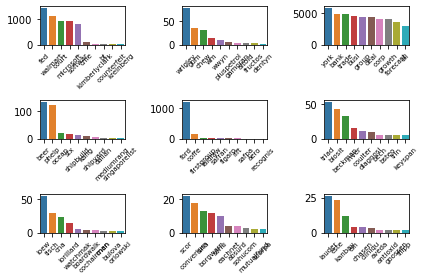

In [17]:
# distribution of words in 9 topics

fig = plt.figure()
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    topic_counts_df = df_word_count.loc[topic_words[i]].sort_values(by = 'count', ascending = False)
    sns.barplot(x = topic_counts_df.index, y = 'count', data = topic_counts_df)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(rotation=45, fontsize=7)
    plt.tight_layout()

    


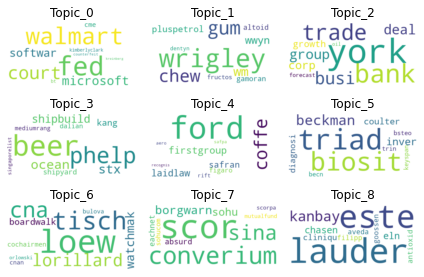

In [18]:
# world cloud of words in 9 topics

from wordcloud import WordCloud
fig = plt.figure()
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    topic_counts_df = df_word_count.loc[topic_words[i]].sort_values(by = 'count', ascending = False)
    word_dict =  {word : count for word, count in zip(topic_counts_df.index, topic_counts_df['count'].values)}
    wordcloud = WordCloud(background_color ='white')
    wordcloud.generate_from_frequencies(frequencies=word_dict)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Topic_'+ str(i))
    plt.tight_layout()

## Finding news sentiments

In [8]:
#remove punctuations and non-alpha words 
def clean_text(text):
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    words = ' '.join(words)
    return words
    


#Find News titles Sentiment using the updated lexicon of vaderSentiment
#To Do: add the news content for as the feature

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def sentiment_score_vade(sent):
    
    '''
    find the sentiment of news with the updated lexicon
    retruns: total poliarity of sentences (positve + negative + nuetral)
    '''
    
    sia = SentimentIntensityAnalyzer()
    new_words = {
        'crushes': 10,
        'beats': 5,
        'misses': -5,
        'trouble': -10,
        'falls': -100,
    }
    sia.lexicon.update(new_words)
    return sia.polarity_scores(sent)['compound']

## DataFrame preprarion

Pulling Dow Jones Industrial average and Mergeing/alingning with the sentiment data

In [9]:
#make a dataframe using dates and titles and the corosponding sentiment

import pandas as pd

df = pd.DataFrame({"date": dates, "title": titles})
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace = True)
df = df.sort_index()
df['sentiment'] = df.apply(sentiment_score_vade, axis = 1)

In [ ]:
df.index = df.index.strftime('%Y-%m-%d')

In [12]:
# Getting historical data for Dow Jones Industrial Average index

ticker = 'DJI'
sdate = df.index[0]
edate = df.index[-1]

price_data = yf.download(ticker, sdate, edate)

[*********************100%***********************]  1 of 1 completed


In [13]:
price_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-02-22,12381.000000,12381.000000,12381.000000,12381.000000,12381.000000,0
2008-02-25,12570.200195,12570.200195,12570.200195,12570.200195,12570.200195,0
2008-02-26,12684.900391,12684.900391,12684.900391,12684.900391,12684.900391,0
2008-02-27,12694.299805,12694.299805,12694.299805,12694.299805,12694.299805,0
2008-02-28,12582.200195,12582.200195,12582.200195,12582.200195,12582.200195,0


In [14]:
#Compute the standardize (centered by the mean and divided by std) 5-days rolling average of news sentiment

r_wind = 5 
tol = 0.0001
df['std_sentiment'] = (df['sentiment'] - df['sentiment'].rolling(r_wind).mean())/(df['sentiment'].rolling(r_wind).std()+tol)

In [15]:
df_mix_all = pd.merge(price_data, df[["std_sentiment"]], left_index = True, right_index = True)
df_mix_all.fillna(method='bfill', inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c67172d00>,
      dtype=object)

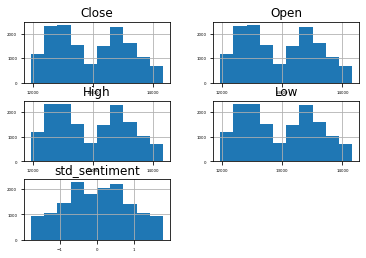

In [16]:
# Plot a histogram for few columns of the dataframe which shows the distribution of values
df_mix_all[["Close", "Open", "High", "Low", "std_sentiment"]].hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4)

In [19]:
#We use only "Close" price and news sentiments as features of our model
#Merge historical data and news sentiments and handle missing values

df_mix = pd.merge(price_data[["Close"]], df[["std_sentiment"]], left_index = True, right_index = True)
df_mix.fillna(method='bfill', inplace=True)

In [20]:
df_mix.describe()

,Close,std_sentiment
count,15176.000000,1.517600e+04
mean,12964.789762,-2.622384e-03
std,587.925574,8.870095e-01
min,11971.200195,-1.788454e+00
25%,12442.200195,-6.618594e-01
50%,12958.400391,-1.332031e-12
75%,13463.299805,6.582234e-01
max,14164.500000,1.788426e+00


In [ ]:
# picle the mixed datafarme
df_mix.to_pickle("./data_mix.pkl")
# df_mix = pd.read_pickle('./data_mix.pkl')
# df_mix.head()

## Time series visualization

Text(0.5, 1.0, 'Dow Jones Industrial Average')

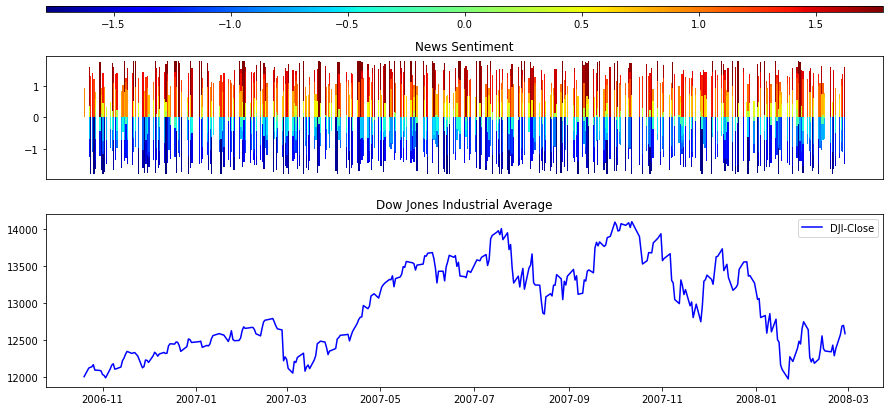

In [114]:
#visualizing the news sentiment and the historical data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mask_step = 4
my_cmap = cm.get_cmap('jet')
# my_cmap = cm.get_cmap('Spectral')
sent_vals = df_mix[['std_sentiment']].values[:, 0]
my_norm = Normalize(vmin=min(sent_vals), vmax=max(sent_vals))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
ax1.bar(df_mix.index.values[::mask_step], sent_vals[::mask_step], color = my_cmap(my_norm(sent_vals[::mask_step])), label = 'New-sentiment')
ax1.set_title('News Sentiment')
ax1.axes.xaxis.set_visible(False)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.6)
cax.xaxis.set_ticks_position("top")

fig.add_axes(cax)

plt.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap),
             cax=cax,
             orientation='horizontal', fraction=0.02,anchor=(1.0,0.0))


ax2.plot(df_mix.index, df_mix[["Close"]], c = 'b', label = 'DJI-Close')
ax2.legend()
ax2.set_title('Dow Jones Industrial Average')


## Baseline

In [333]:

df_mix = pd.merge(price_data[["Close", "Open", "High", "Low"]], df[["std_sentiment"]], left_index = True, right_index = True)
df_mix.fillna(method='bfill', inplace=True)

In [334]:
df_mix.head(10)

,Close,Open,High,Low,std_sentiment
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,0.933414
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,0.933414
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,0.933414
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-0.097705
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-0.097705
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,0.498918
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,0.360389
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-0.724063
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-0.724063
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-1.482735


In [335]:
#take the average of all news sentiments in a day
df_mix = df_mix.groupby(df_mix.index).mean()

In [203]:
df_mix.to_pickle("./data_mix.pkl")

In [336]:
#standardize the data
def minmax_transform(df):
    df_vals = df_mix.values
    for i, col in enumerate(df.columns):
        scaler = MinMaxScaler(feature_range=(0,1))
        df[col + '_normd'] = scaler.fit_transform(df_vals[:, i].reshape(-1,1))
        
    return df
        
minmax_transform(df_mix)

,Close,Open,High,Low,std_sentiment,Close_normd,Open_normd,High_normd,Low_normd,std_sentiment_normd
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,0.933414,0.014225,0.014225,0.014225,0.014225,1.000000
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,-0.081187,0.066430,0.066430,0.066430,0.066430,0.085286
2006-10-24,12127.900391,12127.900391,12127.900391,12127.900391,0.102231,0.071445,0.071445,0.071445,0.071445,0.250647
2006-10-25,12134.700195,12134.700195,12134.700195,12134.700195,0.000761,0.074545,0.074545,0.074545,0.074545,0.159167
2006-10-26,12163.700195,12163.700195,12163.700195,12163.700195,-0.027549,0.087767,0.087767,0.087767,0.087767,0.133644
...,...,...,...,...,...,...,...,...,...,...
2008-02-22,12381.000000,12381.000000,12381.000000,12381.000000,0.005960,0.186842,0.186842,0.186842,0.186842,0.163854
2008-02-25,12570.200195,12570.200195,12570.200195,12570.200195,-0.057495,0.273104,0.273104,0.273104,0.273104,0.106646
2008-02-26,12684.900391,12684.900391,12684.900391,12684.900391,0.000636,0.325400,0.325400,0.325400,0.325400,0.159054
2008-02-27,12694.299805,12694.299805,12694.299805,12694.299805,-0.071790,0.329686,0.329686,0.329686,0.329686,0.093758


In [255]:
df_mix.drop(['Close', 'Open', 'High', 'Low'], axis = 1, inplace = True)

In [337]:
df_mix = df_mix[['Close_normd', 'std_sentiment']]

In [338]:
df_mix

,Close_normd,std_sentiment
2006-10-20,0.014225,0.933414
2006-10-23,0.066430,-0.081187
2006-10-24,0.071445,0.102231
2006-10-25,0.074545,0.000761
2006-10-26,0.087767,-0.027549
...,...,...
2008-02-22,0.186842,0.005960
2008-02-25,0.273104,-0.057495
2008-02-26,0.325400,0.000636
2008-02-27,0.329686,-0.071790


In [339]:
# train and test split

n = len(df_mix)
train_df = df_mix[:int(n*0.7)]
val_df = df_mix[int(0.7*n):int(0.9*n)]
test_df = df_mix[int(0.9*n):-1]

num_features = df_mix.shape[1]

column_indices = {name: i for i, name in enumerate(df_mix.columns)}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bdd66dca0>],
      dtype=object)

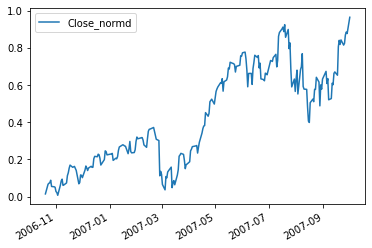

In [315]:
train_df.plot(subplots=True)

## Preparing data sequnces and series generation using tensorflow Datasets

Creating window sequences with WindowGenerator class to make label and input series for train, validation and test. Spliting and converting to tf.data.Dataset for batching to be fed to the network for training.

In [340]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

          # Slicing doesn't preserve static shape information, so set the shapes
          # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
        ds = ds.map(self.split_window)

        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    def plot(self, model=None, plot_col = 'Close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index


        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
              plt.legend()

        plt.xlabel('date')
    
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [317]:
w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=['Close_normd'])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close_normd']

In [318]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline, Dense, Convolutional and LSTM models
Before building a trainable model it would be good to have a 
performance baseline as a point for comparison with the later more complicated models.
This first task is to predict price one day in the future given the current value of all features.

In [341]:
val_performance = {}
performance = {}

In [422]:
#predicting one day ahead with one day input 
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close_normd'])

#predicting input_width days , one day ahead with input_width
wide_window = WindowGenerator(
    input_width = 3, label_width=1, shift=1,
    label_columns=['Close_normd'])

In [412]:
#predicting one day ahead with one day input 
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close_normd'])

#predicting input_width days , one day ahead with input_width
wide_window = WindowGenerator(
    input_width = 3, label_width=1, shift=1,
    label_columns=['Close_normd'])



baseline = Baseline(label_index=column_indices['Close_normd'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


2/2 [==============================] - 0s 5ms/step - loss: 0.0179 - mean_absolute_error: 0.1140


In [368]:
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close_normd']

## Linear Model

In [429]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 80

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

history = compile_and_fit(linear, wide_window)
#single_step_window
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)


Epoch 1/80
8/8 [==============================] - 3s 387ms/step - loss: 0.3854 - mean_absolute_error: 0.5360 - val_loss: 0.6768 - val_mean_absolute_error: 0.7979
Epoch 2/80
8/8 [==============================] - 0s 35ms/step - loss: 0.3628 - mean_absolute_error: 0.5084 - val_loss: 0.6554 - val_mean_absolute_error: 0.7847
Epoch 3/80
8/8 [==============================] - 0s 30ms/step - loss: 0.3438 - mean_absolute_error: 0.4933 - val_loss: 0.6344 - val_mean_absolute_error: 0.7714
Epoch 4/80
8/8 [==============================] - 0s 32ms/step - loss: 0.3447 - mean_absolute_error: 0.4957 - val_loss: 0.6137 - val_mean_absolute_error: 0.7582
Epoch 5/80
8/8 [==============================] - 0s 28ms/step - loss: 0.3126 - mean_absolute_error: 0.4713 - val_loss: 0.5936 - val_mean_absolute_error: 0.7451
Epoch 6/80
8/8 [==============================] - 0s 28ms/step - loss: 0.3099 - mean_absolute_error: 0.4698 - val_loss: 0.5740 - val_mean_absolute_error: 0.7321
Epoch 7/80
8/8 [=================

8/8 [==============================] - 0s 26ms/step - loss: 0.0704 - mean_absolute_error: 0.2223 - val_loss: 0.1246 - val_mean_absolute_error: 0.3157
Epoch 52/80
8/8 [==============================] - 0s 28ms/step - loss: 0.0667 - mean_absolute_error: 0.2138 - val_loss: 0.1207 - val_mean_absolute_error: 0.3099
Epoch 53/80
8/8 [==============================] - 0s 24ms/step - loss: 0.0705 - mean_absolute_error: 0.2252 - val_loss: 0.1170 - val_mean_absolute_error: 0.3042
Epoch 54/80
8/8 [==============================] - 0s 23ms/step - loss: 0.0636 - mean_absolute_error: 0.2088 - val_loss: 0.1136 - val_mean_absolute_error: 0.2989
Epoch 55/80
8/8 [==============================] - 0s 23ms/step - loss: 0.0637 - mean_absolute_error: 0.2143 - val_loss: 0.1101 - val_mean_absolute_error: 0.2934
Epoch 56/80
8/8 [==============================] - 0s 25ms/step - loss: 0.0626 - mean_absolute_error: 0.2118 - val_loss: 0.1068 - val_mean_absolute_error: 0.2882
Epoch 57/80
8/8 [=======================

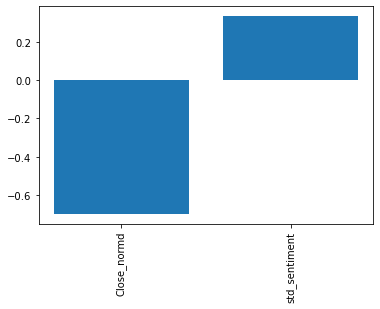

In [424]:
#importance of eache feature baed on the weights of the linear model

plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense Model

In [425]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 1s 52ms/step - loss: 0.2317 - mean_absolute_error: 0.4078 - val_loss: 0.2466 - val_mean_absolute_error: 0.4744
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1057 - mean_absolute_error: 0.2579 - val_loss: 0.0750 - val_mean_absolute_error: 0.2503
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0277 - mean_absolute_error: 0.1287 - val_loss: 0.0109 - val_mean_absolute_error: 0.0880
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0093 - mean_absolute_error: 0.0813 - val_loss: 0.0059 - val_mean_absolute_error: 0.0614
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0078 - mean_absolute_error: 0.0728 - val_loss: 0.0061 - val_mean_absolute_error: 0.0673
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0928


In [387]:
# Feeding multiple days (3) as an input for one day prediction ahead

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close_normd'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close_normd']

In [377]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [378]:
history = compile_and_fit(multi_step_dense, conv_window)


Epoch 1/50
8/8 [==============================] - 1s 38ms/step - loss: 0.1110 - mean_absolute_error: 0.2785 - val_loss: 0.0612 - val_mean_absolute_error: 0.2221
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0276 - mean_absolute_error: 0.1251 - val_loss: 0.0096 - val_mean_absolute_error: 0.0820
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0084 - mean_absolute_error: 0.0762 - val_loss: 0.0153 - val_mean_absolute_error: 0.1030
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0104 - mean_absolute_error: 0.0871 - val_loss: 0.0121 - val_mean_absolute_error: 0.0907


## 1D Convolution model

A convolution layer takes multiple time steps as input to each prediction.

In [402]:
# Feeding multiple days (3) as an input for one day prediction ahead

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close_normd'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close_normd']

In [403]:
MAX_EPOCHS = 100
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [404]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/100
8/8 [==============================] - 1s 43ms/step - loss: 0.1495 - mean_absolute_error: 0.3287 - val_loss: 0.1508 - val_mean_absolute_error: 0.3684
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0647 - mean_absolute_error: 0.2030 - val_loss: 0.0621 - val_mean_absolute_error: 0.2273
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0287 - mean_absolute_error: 0.1319 - val_loss: 0.0194 - val_mean_absolute_error: 0.1182
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0099 - mean_absolute_error: 0.0836 - val_loss: 0.0074 - val_mean_absolute_error: 0.0735
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0084 - mean_absolute_error: 0.0767 - val_loss: 0.0078 - val_mean_absolute_error: 0.0733
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0076 - mean_absolute_error: 0.0727 - val_loss: 0.0071 - val_mean_absolute_error: 0.0710
Epoch 7/100
8/8 [===========

In [274]:
#The convolutional layer is applied to a sliding window of inputs
# Note the 3 input time steps before the first prediction. 
#Every prediction here is based on the 3 preceding timesteps

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close_normed'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Close_normed']

In [287]:
wide_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [1 2 3 4 5]
Label column name(s): ['Close_normd']

## Recurrent Net

RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [406]:
MAX_EPOCHS = 200

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, conv_window)

val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/200
8/8 [==============================] - 2s 85ms/step - loss: 0.3033 - mean_absolute_error: 0.4728 - val_loss: 0.4489 - val_mean_absolute_error: 0.6459
Epoch 2/200
8/8 [==============================] - 0s 26ms/step - loss: 0.2273 - mean_absolute_error: 0.3948 - val_loss: 0.3672 - val_mean_absolute_error: 0.5803
Epoch 3/200
8/8 [==============================] - 0s 27ms/step - loss: 0.1818 - mean_absolute_error: 0.3416 - val_loss: 0.2951 - val_mean_absolute_error: 0.5144
Epoch 4/200
8/8 [==============================] - 0s 29ms/step - loss: 0.1402 - mean_absolute_error: 0.2967 - val_loss: 0.2329 - val_mean_absolute_error: 0.4479
Epoch 5/200
8/8 [==============================] - 0s 28ms/step - loss: 0.1025 - mean_absolute_error: 0.2475 - val_loss: 0.1821 - val_mean_absolute_error: 0.3830
Epoch 6/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0869 - mean_absolute_error: 0.2229 - val_loss: 0.1420 - val_mean_absolute_error: 0.3224
Epoch 7/200
8/8 [===========

8/8 [==============================] - 0s 18ms/step - loss: 0.0085 - mean_absolute_error: 0.0719 - val_loss: 0.0118 - val_mean_absolute_error: 0.0882
Epoch 52/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0089 - mean_absolute_error: 0.0734 - val_loss: 0.0116 - val_mean_absolute_error: 0.0877
Epoch 53/200
8/8 [==============================] - 0s 28ms/step - loss: 0.0083 - mean_absolute_error: 0.0710 - val_loss: 0.0112 - val_mean_absolute_error: 0.0861
Epoch 54/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0085 - mean_absolute_error: 0.0722 - val_loss: 0.0110 - val_mean_absolute_error: 0.0855
Epoch 55/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0078 - mean_absolute_error: 0.0684 - val_loss: 0.0109 - val_mean_absolute_error: 0.0854
Epoch 56/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0080 - mean_absolute_error: 0.0695 - val_loss: 0.0108 - val_mean_absolute_error: 0.0849
Epoch 57/200
8/8 [=================

## Performance comparison of models

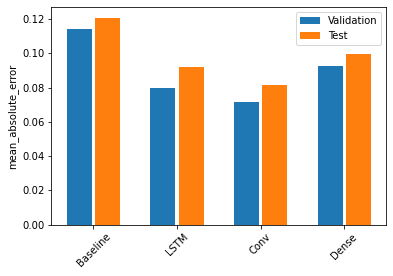

In [434]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Time series preperation and training/evaluation of the LSTM network 

In [52]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
scaler = MinMaxScaler(feature_range=(0,1))

In [68]:

def scale_conform_data_series(df_mix, window = 32):
    '''
    Train and test time series features (news sentiment and DJIa) split by 90-10%
    '''
    
    df_2d_vals = df_mix.values
    scaler = MinMaxScaler(feature_range=(0,1))
    x2 = scaler.fit_transform(df_2d_vals[:, 1].reshape(-1,1))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(df_2d_vals[:, 0].reshape(-1, 1))
    x1 = scaler.transform(df_2d_vals[:, 0].reshape(-1, 1))
    
    x_size=x1.shape[0]
    x_train, x_test = np.c_[x1[:round(x_size*0.9)], x2[:round(x_size*0.9)]], np.c_[x1[round(x_size*0.9):], x2[round(x_size*0.9):]]
    x1_train, x1_test = x1[:round(x_size*0.9)], x1[round(x_size*0.9):]
    x1_train, x1_test = np.array(x1_train).reshape(-1, 1), np.array(x1_test).reshape(-1, 1)
    x_train_data, y_train_data, x1_train_data, y1_train_data=[], [], [], []

    for i in range(window, len(x_train)):
        x_train_data.append(x_train[i-window:i,:])
        x1_train_data.append(x1_train[i-window:i, 0])
        y_train_data.append(x_train[i,0])
        y1_train_data.append(x_train[i,0])
        
    x_train_data = np.array(x_train_data)
    x1_train_data = np.array(x1_train_data)
    x1_train_data = x1_train_data.reshape(x1_train_data.shape[0], x1_train_data.shape[1], 1)
    y_train_data = np.array(y_train_data).reshape(-1, 1)
    y1_train_data = np.array(y1_train_data).reshape(-1, 1)
    
    return x_train_data, x1_train_data, y_train_data, y1_train_data, x1_train, x1_test 

In [69]:
x_train_data, x1_train_data, y_train_data, y1_train_data, x1_train, x1_test = scale_conform_data_series(df_mix)

In [75]:
#building and training a shallow LSTM model. The model takes the historical time series and the scaled news 
# sentiment time-series in 32-days window  as input to predict the DJI avg-index for the next day.
# we can use LearningRateScheduler to find the optimal learning rate

#2D-model:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, input_shape = (x_train_data.shape[1], 2))))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(1))

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 10))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
model.compile(loss='mean_squared_error',optimizer='adam', metrics=["mae"])
# history = model.fit(x_train_data, y_train_data, epochs = 40, callbacks=[lr_schedule])
history = model.fit(x_train_data, y_train_data, epochs= 40)

Epoch 1/40
409/409 [==============================] - 18s 44ms/step - loss: 0.0046 - mae: 0.0270
Epoch 2/40
409/409 [==============================] - 17s 41ms/step - loss: 4.1057e-04 - mae: 0.0119
Epoch 3/40
409/409 [==============================] - 17s 41ms/step - loss: 2.6807e-04 - mae: 0.0085
Epoch 4/40
409/409 [==============================] - 17s 41ms/step - loss: 2.2962e-04 - mae: 0.0080
Epoch 5/40
409/409 [==============================] - 16s 40ms/step - loss: 1.9746e-04 - mae: 0.0070
Epoch 6/40
409/409 [==============================] - 17s 41ms/step - loss: 1.9811e-04 - mae: 0.0075
Epoch 7/40
409/409 [==============================] - 16s 39ms/step - loss: 1.6298e-04 - mae: 0.0059
Epoch 8/40
409/409 [==============================] - 17s 40ms/step - loss: 1.5941e-04 - mae: 0.0061
Epoch 9/40
409/409 [==============================] - 16s 40ms/step - loss: 1.5963e-04 - mae: 0.0065
Epoch 10/40
409/409 [==============================] - 17s 41ms/step - loss: 1.5046e-04 - mae: 

In [88]:
model.save("./saved_lstm_model.h5")

Text(0, 0.5, 'Men Absolute Error')

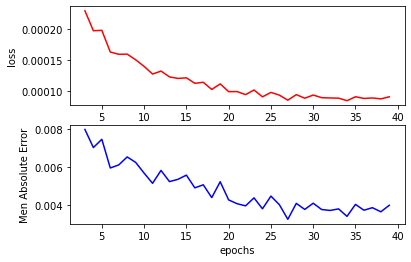

In [99]:
#plots of Loss and error fot the training rounds
st_ep = 3
fig, (ax_1, ax_2) = plt.subplots(2,1)
xrange = range(st_ep, len(history.history['loss']))
ax_1.plot(xrange, history.history['loss'][st_ep:], c = 'r')

ax_1.set_ylabel('loss')
ax_2.plot(xrange, history.history['mae'][st_ep:], c = 'b')
ax_2.set_xlabel('epochs')
ax_2.set_ylabel('Men Absolute Error')


(1e-08, 0.0001, 0.0, 30.0)

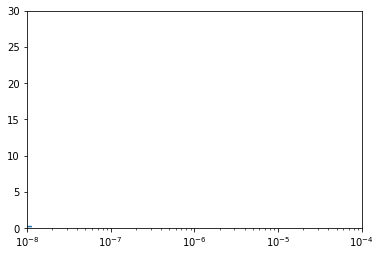

In [71]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [80]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#preparpe the test set sequence based on the window size of 32 days and inverse the preprocessing transformations

window = 32
X_test=[]
for i in range(window ,x_test.shape[0]):
    X_test.append(x_test[i-window:i,:])
X_test=np.array(X_test)

# X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted = model.predict(X_test)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_2d_vals[:, 0].reshape(-1, 1))
x1 = scaler.transform(df_2d_vals[:, 0].reshape(-1, 1))
predicted_inv = scaler.inverse_transform(predicted)
x1_train_inv = scaler.inverse_transform(x1_train)
x1_test_inv = scaler.inverse_transform(x1_test)
std_scaler = StandardScaler()

sent_vals_std = std_scaler.fit_transform(sent_vals.reshape(-1, 1))

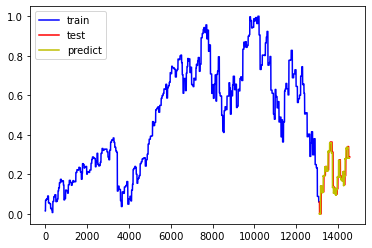

In [81]:
plt.plot(np.arange(len(x1_train)),x1_train[:,0], c='b', label = 'train')
plt.plot(np.arange(len(x1_train),len(x1_train)+len(x1_test)),x1_test[:,0], c='r', label = 'test')
plt.plot(np.arange(len(x1_train),len(x1_train)+len(predicted)),predicted[:,0], c='y', label = 'predict')
plt.legend()

## Visualizaing predictions 

Text(0.5, 1.0, 'Dow Jones Industrial Average')

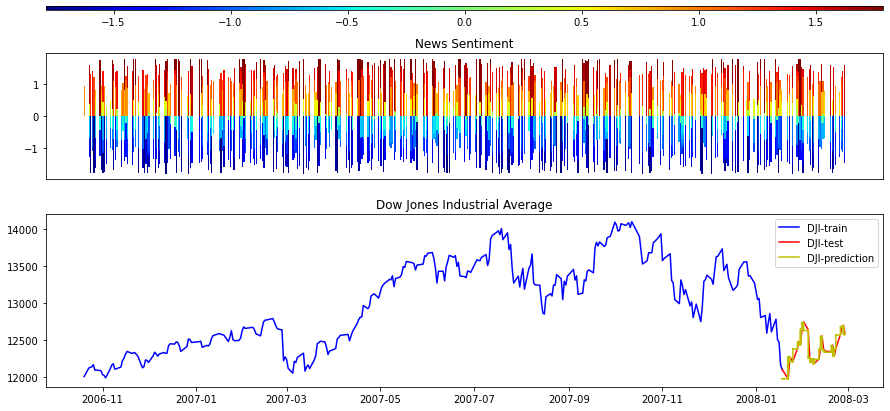

In [112]:
#Plotting the prediction results on the test set from '2008-01-17' to '2008-02-28 on the window size of 32 

mask_step = 4
my_cmap = cm.get_cmap('jet')
# my_cmap = cm.get_cmap('Spectral')
sent_vals = df_mix[['std_sentiment']].values[:, 0]
my_norm = Normalize(vmin=min(sent_vals), vmax=max(sent_vals))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
ax1.bar(df_mix.index.values[::mask_step], sent_vals[::mask_step], color = my_cmap(my_norm(sent_vals[::mask_step])), label = 'New-sentiment')
ax1.set_title('News Sentiment')
ax1.axes.xaxis.set_visible(False)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size=0.05, pad=.6)
cax.xaxis.set_ticks_position("top")
fig.add_axes(cax)

plt.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap),
             cax=cax,
             orientation='horizontal', fraction=0.02,anchor=(1.0,0.0))


ax2.plot(df_mix.index.values[:len(x1_train_inv)], x1_train_inv[:,0], c = 'b', label = 'DJI-train')
ax2.plot(df_mix.index.values[len(x1_train):len(x1_train)+len(x1_test)], x1_test_inv[:,0], c = 'r', label = 'DJI-test')
ax2.plot(df_mix.index.values[len(x1_train): len(x1_train)+len(predicted)], predicted_inv[:,0], c = 'y', label = 'DJI-prediction')
ax2.legend()
ax2.set_title('Dow Jones Industrial Average')



In [ ]:
plt.savefig('DJI-predict-plot.png')

In [ ]:
# Alternative data_preperation for the LSTM network 

In [ ]:
train_size = 14569 - 500
train, test = df_mix[:train_size] , df_mix[train_size:]
train_v , test_v = train.values, test.values  
sc_train, sc_test = scaler.fit_transform(train_v), scaler.fit_transform(test_v)

In [ ]:
# using tensorflow to generate windowed datase. 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shift_v):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=shift_v, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + shift_v))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-shift_v], window[-shift_v:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

shift_v = 1

train_dataset = windowed_dataset(sc_train, window_size, batch_size, shuffle_buffer_size, shift_v)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None, None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(shift_v),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=10, callbacks=[lr_schedule])

In [ ]:
model.save("./saved_lstm_model.h5")

In [ ]:
series_len = 14569
forecast = []
results = []
for time in range(series_len - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]

In [ ]:
model.predict(series[time:time + window_size][np.newaxis])